In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PSID
from PSID.evaluation import evalPrediction
from src.cross_validation_PSID import cross_validation, cross_validation_split
from src.explore_state_dimensions import plot_explorations
from src.explore_state_dimensions import explore_latent_behavior_dims
%load_ext autoreload
%autoreload 2

# explore dimensions of behaviorally relevant dynamics
# in here all latent space dimensions will be used to prioritize behavior, meaning n1 = nx

PATH_FEATURES = "/home/lauraflyra/Documents/BCCN/Lab_Rotation_USC/Code/Data/py_neuromodulation_derivatives/sub-000_ses-right_task-force_run-3/sub-000_ses-right_task-force_run-3_FEATURES.csv"
data_features = pd.read_csv(PATH_FEATURES, index_col=0)

# Start with bandpass features

In [2]:
feature_df_bandpass = pd.concat([data_features.filter(like='STN'),data_features.filter(like='ECOG')], axis = 1).filter(like='bandpass_activity').to_numpy()
behavior_df = data_features["MOV_LEFT_CLEAN"].to_numpy().reshape(-1, 1)

In [3]:
K_FOLDS = 5
N_DIMS = 15

Cross validation results from XGBOOST with $R^{2}$ for bandpass features:
mean $R^{2}$ = 0.675
std = 0.056

In [4]:
xgboost_mean_r2_bandpass = 0.675
xgboost_std_r2_bandpass = 0.056

In [6]:
i_s = [10,20, 35, 45, 55]
evals = []
behavior_dims_latents =[]
for i in i_s:
    eval,behavior_dims_latent = explore_latent_behavior_dims(neural = feature_df_bandpass, behavior= behavior_df, k_folds=5, n_dims=15, max_dim=i,i=i, cv_eval='R2')
    evals.append(eval)
    behavior_dims_latents.append(behavior_dims_latent)


Behavior decoding evaluation:
  PSID => 0.624
Behavior decoding evaluation:
  PSID => 0.7
Behavior decoding evaluation:
  PSID => 0.693
Behavior decoding evaluation:
  PSID => 0.644
Behavior decoding evaluation:
  PSID => 0.71
Behavior decoding evaluation:
  PSID => 0.624
Behavior decoding evaluation:
  PSID => 0.7
Behavior decoding evaluation:
  PSID => 0.693
Behavior decoding evaluation:
  PSID => 0.644
Behavior decoding evaluation:
  PSID => 0.71
Behavior decoding evaluation:
  PSID => 0.625
Behavior decoding evaluation:
  PSID => 0.727
Behavior decoding evaluation:
  PSID => 0.708
Behavior decoding evaluation:
  PSID => 0.646
Behavior decoding evaluation:
  PSID => 0.715
Behavior decoding evaluation:
  PSID => 0.625
Behavior decoding evaluation:
  PSID => 0.727
Behavior decoding evaluation:
  PSID => 0.708
Behavior decoding evaluation:
  PSID => 0.646
Behavior decoding evaluation:
  PSID => 0.715
Behavior decoding evaluation:
  PSID => 0.62
Behavior decoding evaluation:
  PSID => 0

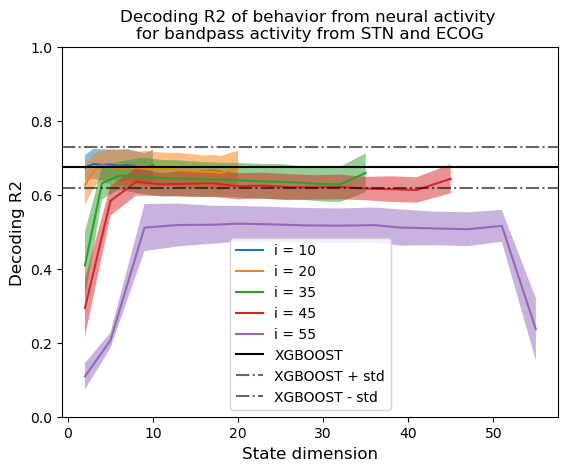

In [12]:
metrics = "R2"
feature_type = "bandpass activity"
channel_type = 'STN and ECOG'
for j in range(len(i_s)):
        plt.plot(behavior_dims_latents[j], np.mean(evals[j], axis=1), label="i = {}".format(i_s[j]))
        plt.fill_between(behavior_dims_latents[j],
                         np.mean(evals[j], axis=1) - np.std(evals[j], axis=1),
                         np.mean(evals[j], axis=1) + np.std(evals[j], axis=1),
                         alpha=0.5)
plt.axhline(y=xgboost_mean_r2_bandpass, color='black', linestyle='-', label='XGBOOST')
plt.axhline(y=xgboost_mean_r2_bandpass + xgboost_std_r2_bandpass, color='black', linestyle='-.',
            label='XGBOOST + std', alpha=0.6)
plt.axhline(y=xgboost_mean_r2_bandpass - xgboost_std_r2_bandpass, color='black', linestyle='-.',
            label='XGBOOST - std', alpha=0.6)
plt.ylim(0, 1)
plt.ylabel("Decoding " + metrics, fontsize=12)
plt.xlabel("State dimension", fontsize=12)
plt.legend()
plt.title(
    "Decoding " + metrics + " of behavior from neural activity \nfor " + feature_type + " from " + channel_type,
    fontsize=12)
plt.show()

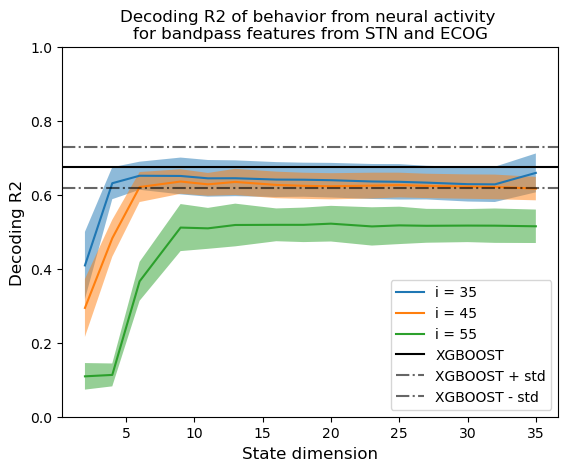

In [7]:
plot_explorations(evals, behavior_dims_latent, i_s,xgboost_mean=xgboost_mean_r2_bandpass, xgboost_std=xgboost_std_r2_bandpass)

# Explore FFT features

In [8]:
feature_df_fft = pd.concat([data_features.filter(like='STN'),data_features.filter(like='ECOG')], axis = 1).filter(like='fft').to_numpy()
behavior_df = data_features["MOV_LEFT_CLEAN"].to_numpy().reshape(-1, 1)

Cross validation results from XGBOOST with $R^{2}$ for FFT features:
mean $R^{2}$ = 0.305
std = 0.211

In [9]:
xgboost_mean_r2_fft = 0.305
xgboost_std_r2_fft = 0.211

In [10]:
i_s = [30, 40, 50]
evals_fft = []
for i in i_s:
    eval,behavior_dims_latent = explore_latent_behavior_dims(neural = feature_df_fft, behavior= behavior_df, k_folds=5, n_dims=15, max_dim=30,i=i, cv_eval='R2')
    evals_fft.append(eval)


Behavior decoding evaluation:
  PSID => 0.183
Behavior decoding evaluation:
  PSID => 0.175
Behavior decoding evaluation:
  PSID => 0.208
Behavior decoding evaluation:
  PSID => 0.131
Behavior decoding evaluation:
  PSID => 0.25
Behavior decoding evaluation:
  PSID => 0.451
Behavior decoding evaluation:
  PSID => 0.418
Behavior decoding evaluation:
  PSID => 0.445
Behavior decoding evaluation:
  PSID => 0.442
Behavior decoding evaluation:
  PSID => 0.446
Behavior decoding evaluation:
  PSID => 0.482
Behavior decoding evaluation:
  PSID => 0.508
Behavior decoding evaluation:
  PSID => 0.516
Behavior decoding evaluation:
  PSID => 0.532
Behavior decoding evaluation:
  PSID => 0.538
Behavior decoding evaluation:
  PSID => 0.462
Behavior decoding evaluation:
  PSID => 0.504
Behavior decoding evaluation:
  PSID => 0.533
Behavior decoding evaluation:
  PSID => 0.55
Behavior decoding evaluation:
  PSID => 0.557
Behavior decoding evaluation:
  PSID => 0.472
Behavior decoding evaluation:
  PSID

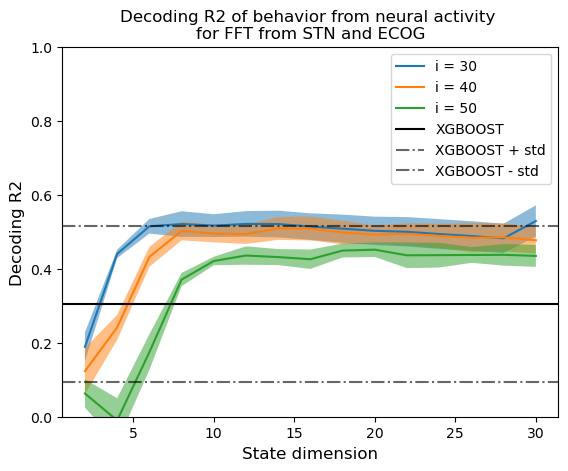

In [13]:
plot_explorations(evals_fft, behavior_dims_latent, i_s,xgboost_mean=xgboost_mean_r2_fft, xgboost_std=xgboost_std_r2_fft, feature_type='FFT')

# Explore Sharpwave features

In [8]:
feature_df_sw = data_features.filter(like='ECOG_RIGHT_4').filter(like='Sharpwave_Mean').to_numpy()
behavior_df = data_features["MOV_LEFT_CLEAN"].to_numpy().reshape(-1, 1)

In [12]:
data_features.filter(like='ECOG_RIGHT_4').filter(like='Sharpwave_Mean').keys()

Index(['ECOG_RIGHT_4-avgref_Sharpwave_Mean_peak_left_range_5_80',
       'ECOG_RIGHT_4-avgref_Sharpwave_Mean_peak_right_range_5_80',
       'ECOG_RIGHT_4-avgref_Sharpwave_Mean_trough_range_5_80',
       'ECOG_RIGHT_4-avgref_Sharpwave_Mean_width_range_5_80',
       'ECOG_RIGHT_4-avgref_Sharpwave_Mean_prominence_range_5_80',
       'ECOG_RIGHT_4-avgref_Sharpwave_Mean_interval_range_5_80',
       'ECOG_RIGHT_4-avgref_Sharpwave_Mean_decay_time_range_5_80',
       'ECOG_RIGHT_4-avgref_Sharpwave_Mean_rise_time_range_5_80',
       'ECOG_RIGHT_4-avgref_Sharpwave_Mean_sharpness_range_5_80',
       'ECOG_RIGHT_4-avgref_Sharpwave_Mean_rise_steepness_range_5_80',
       'ECOG_RIGHT_4-avgref_Sharpwave_Mean_decay_steepness_range_5_80',
       'ECOG_RIGHT_4-avgref_Sharpwave_Mean_slope_ratio_range_5_80',
       'ECOG_RIGHT_4-avgref_Sharpwave_Mean_peak_left_range_5_30',
       'ECOG_RIGHT_4-avgref_Sharpwave_Mean_peak_right_range_5_30',
       'ECOG_RIGHT_4-avgref_Sharpwave_Mean_trough_range_5_30',
    

In [9]:
i_s = [30, 40, 50]
evals_sw = []
for i in i_s:
    eval,behavior_dims_latent_sw = explore_latent_behavior_dims(neural = feature_df_sw, behavior= behavior_df, k_folds=5, n_dims=15, max_dim=30,i=i, cv_eval='R2')
    evals_sw.append(eval)


Behavior decoding evaluation:
  PSID => -1.64
Behavior decoding evaluation:
  PSID => 0.287
Behavior decoding evaluation:
  PSID => 0.187
Behavior decoding evaluation:
  PSID => 0.271
Behavior decoding evaluation:
  PSID => 0.291
Behavior decoding evaluation:
  PSID => -34.4
Behavior decoding evaluation:
  PSID => 0.334
Behavior decoding evaluation:
  PSID => 0.307
Behavior decoding evaluation:
  PSID => 0.345
Behavior decoding evaluation:
  PSID => 0.415
Behavior decoding evaluation:
  PSID => -338
Behavior decoding evaluation:
  PSID => 0.343
Behavior decoding evaluation:
  PSID => 0.368
Behavior decoding evaluation:
  PSID => 0.363
Behavior decoding evaluation:
  PSID => 0.404
Behavior decoding evaluation:
  PSID => -505
Behavior decoding evaluation:
  PSID => 0.349
Behavior decoding evaluation:
  PSID => 0.353
Behavior decoding evaluation:
  PSID => 0.36
Behavior decoding evaluation:
  PSID => 0.418
Behavior decoding evaluation:
  PSID => -947
Behavior decoding evaluation:
  PSID =

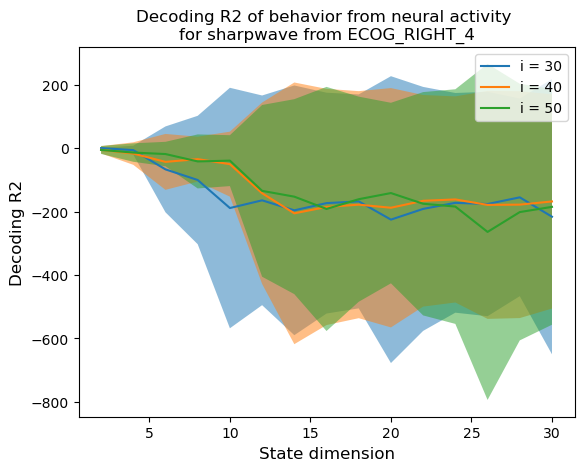

In [11]:
plot_explorations(evals_sw, behavior_dims_latent_sw, i_s,plot_xgboost=False, feature_type='sharpwave',channel_type='ECOG_RIGHT_4')

# Explore with sub-003

In [4]:
PATH_FEATURES_S3 = "/home/lauraflyra/Documents/BCCN/Lab_Rotation_USC/Code/Data/py_neuromodulation_derivatives/sub-003_ses-right_task-force_run-4/sub-003_ses-right_task-force_run-4_FEATURES.csv"
data_features_s3 = pd.read_csv(PATH_FEATURES_S3, index_col=0)

In [5]:
feature_df_s3 = data_features_s3.filter(like='ECOG_RIGHT').filter(like='bandpass_activity').to_numpy()
behavior_s3 = data_features_s3["MOV_LEFT_CLEAN"].to_numpy().reshape(-1, 1)

i_s = [30, 40, 50]
evals_s3 = []
for i in i_s:
    eval, behavior_dims_latent_s3 = explore_latent_behavior_dims(neural=feature_df_s3, behavior=behavior_s3, k_folds=3,
                                                              n_dims=10, max_dim=30, i=i, cv_eval='R2')
    evals_s3.append(eval)

Behavior decoding evaluation:
  PSID => -0.0248
Behavior decoding evaluation:
  PSID => -0.207
Behavior decoding evaluation:
  PSID => -0.0958
Behavior decoding evaluation:
  PSID => -0.113
Behavior decoding evaluation:
  PSID => -0.66
Behavior decoding evaluation:
  PSID => -0.264
Behavior decoding evaluation:
  PSID => -0.0918
Behavior decoding evaluation:
  PSID => -0.688
Behavior decoding evaluation:
  PSID => -0.244
Behavior decoding evaluation:
  PSID => -0.0604
Behavior decoding evaluation:
  PSID => -0.711
Behavior decoding evaluation:
  PSID => -0.25
Behavior decoding evaluation:
  PSID => -0.0647
Behavior decoding evaluation:
  PSID => -0.731
Behavior decoding evaluation:
  PSID => -0.258
Behavior decoding evaluation:
  PSID => -0.0735
Behavior decoding evaluation:
  PSID => -0.716
Behavior decoding evaluation:
  PSID => -0.252
Behavior decoding evaluation:
  PSID => -0.0738
Behavior decoding evaluation:
  PSID => -0.735
Behavior decoding evaluation:
  PSID => -0.261
Behavior

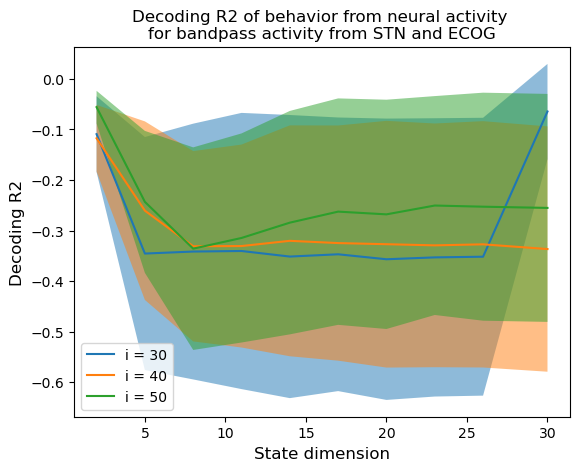

In [9]:
plot_explorations(evals_s3, behavior_dims_latent_s3, i_s,plot_xgboost=False, feature_type='bandpass activity')